In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


# Machine Learning

## Session 14b

### Convert a PyTorch Model to ONNX and OpenVINO IR

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

First, the PyTorch model is exported in ONNX format and then converted to OpenVINO IR. Then the respective ONNX and OpenVINO IR models are loaded into OpenVINO Runtime to show model predictions. In this tutorial, we will use LR-ASPP model with MobileNetV3 backbone.

According to the paper, Searching for MobileNetV3, LR-ASPP or Lite Reduced Atrous Spatial Pyramid Pooling has a lightweight and efficient segmentation decoder architecture. The diagram below illustrates the model architecture:
<img src='../../images/OpenVINO_MobiNet.png' style = 'width:400px;' alt="movinet"/>

The model is pre-trained on the MS COCO dataset. Instead of training on all 80 classes, the segmentation model has been trained on 20 classes from the PASCAL VOC dataset: **background, aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, dining table, dog, horse, motorbike, person, potted plant, sheep, sofa, train, tvmonitor**

[Model Details](https://pytorch.org/vision/main/models/lraspp.html)

In [2]:
import os
import sys
import time
import warnings
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from IPython.display import Markdown, display
from torchvision.models.segmentation import lraspp_mobilenet_v3_large, LRASPP_MobileNet_V3_Large_Weights
from openvino.runtime import Core

sys.path.append("/home/pks/01_projects/CDAC/DHPCAP/notebooks/utils")
from notebook_utils import segmentation_map_to_image, viz_result_image, SegmentationMap, Label, download_file

## Settings
Set a name for the model, then define width and height of the image that will be used by the network during inference. According to the input transforms function, the model is pre-trained on images with a height of 520 and width of 780.

In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of inputs for this module
subDir = 'vino'

# set location of output files
outDir = os.path.join('..', 'output')

# set location of model files
modelDir = os.path.join('..', 'vino_model')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 9),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.brg
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('bmh')

IMAGE_WIDTH = 780
IMAGE_HEIGHT = 520

#DIRECTORY_NAME = "model"
BASE_MODEL_NAME = os.path.join(modelDir, subDir, 'lraspp_mobilenet_v3_large')
weights_path = Path(BASE_MODEL_NAME + ".pt")

# Paths where ONNX and OpenVINO IR models will be stored.
onnx_path = weights_path.with_suffix('.onnx')
if not onnx_path.parent.exists():
    onnx_path.parent.mkdir()
ir_path = onnx_path.with_suffix(".xml")


<Figure size 1500x900 with 0 Axes>

## Load Model
Generally, PyTorch models represent an instance of torch.nn.Module class, initialized by a state dictionary with model weights. Typical steps for getting a pre-trained model: 1. Create instance of model class 2. Load checkpoint state dict, which contains pre-trained model weights 3. Turn model to evaluation for switching some operations to inference mode

The torchvision module provides a ready to use set of functions for model class initialization. We will use torchvision.models.segmentation.lraspp_mobilenet_v3_large. You can directly pass pre-trained model weights to the model initialization function using weights enum LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1. However, for demonstration purposes, we will create it separately. Download the pre-trained weights and load the model. This may take some time if you have not downloaded the model before.

In [4]:
print("Downloading the LRASPP MobileNetV3 model (if it has not been downloaded already)...")
download_file(LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.url, 
              filename=weights_path.name, 
              directory=weights_path.parent)
# create model object
model = lraspp_mobilenet_v3_large()
# read state dict, use map_location argument to avoid a situation where weights are saved in cuda (which may not be unavailable on the system)
state_dict = torch.load(weights_path, map_location='cpu')
# load state dict to model
model.load_state_dict(state_dict)
# switch model from training to inference mode
model.eval()
print("Loaded PyTorch LRASPP MobileNetV3 model")



'../vino_model/vino/lraspp_mobilenet_v3_large.pt' already exists.
Loaded PyTorch LRASPP MobileNetV3 model


## ONNX Model Conversion
### Convert PyTorch model to ONNX

OpenVINO supports PyTorch models that are exported in ONNX format. We will use the torch.onnx.export function to obtain the ONNX model, you can learn more about this feature in the PyTorch documentation. We need to provide a model object, example input for model tracing and path where the model will be saved. When providing example input, it is not necessary to use real data, dummy input data with specified shape is sufficient. Optionally, we can provide a target onnx opset for conversion and/or other parameters specified in documentation (e.g. input and output names or dynamic shapes).

Sometimes a warning will be shown, but in most cases it is harmless, so let us just filter it out.

In [5]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    if not onnx_path.exists():
        dummy_input = torch.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)
        torch.onnx.export(
            model,
            dummy_input,
            onnx_path,
        )
        print(f"ONNX model exported to {onnx_path}.")
    else:
        print(f"ONNX model {onnx_path} already exists.")

ONNX model exported to ../vino_model/vino/lraspp_mobilenet_v3_large.onnx.


## Convert ONNX Model to OpenVINO IR Format

Use Model Optimizer to convert the ONNX model to OpenVINO IR with FP16 precision. The models are saved inside the current directory. For more information about Model Optimizer, see the Model Optimizer Developer Guide.

Executing this command may take a while. There may be some errors or warnings in the output. 

In [6]:
# Construct the command for Model Optimizer.
mo_command = f'mo --input_model "{onnx_path}" --compress_to_fp16 --output_dir "{ir_path.parent}"'
                 
mo_command = " ".join(mo_command.split())

print("Model Optimizer command to convert the ONNX model to OpenVINO:")
display(Markdown(f"`{mo_command}`"))


Model Optimizer command to convert the ONNX model to OpenVINO:


`mo --input_model "../vino_model/vino/lraspp_mobilenet_v3_large.onnx" --compress_to_fp16 --output_dir "../vino_model/vino"`

In [7]:
if not ir_path.exists():
    print("Exporting ONNX model to IR... This may take a few minutes.")
    mo_result = %sx $mo_command
    print("\n".join(mo_result))
else:
    print(f"IR model {ir_path} already exists.")


Exporting ONNX model to IR... This may take a few minutes.
[ INFO ] Generated IR will be compressed to FP16. If you get lower accuracy, please consider disabling compression explicitly by adding argument --compress_to_fp16=False.
Find more information about compression to FP16 at https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_FP16_Compression.html
[ INFO ] MO command line tool is considered as the legacy conversion API as of OpenVINO 2023.2 release. Please use OpenVINO Model Converter (OVC). OVC represents a lightweight alternative of MO and provides simplified model conversion API. 
Find more information about transition from MO to OVC at https://docs.openvino.ai/2023.2/openvino_docs_OV_Converter_UG_prepare_model_convert_model_MO_OVC_transition.html
[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /home/pks/01_projects/CDAC/DHPCAP/vino_model/vino/lraspp_mobilenet_v3_large.xml
[ SUCCESS ] BIN file: /home/pks/01_projects/CDAC/DHPCAP/vino_model/vino/lraspp_mobilenet_

## Show Results

Confirm that the segmentation results look as expected by comparing model predictions on the ONNX, OpenVINO IR and PyTorch models.

In [8]:
def normalize(image: np.ndarray) -> np.ndarray:
    """
    Normalize the image to the given mean and standard deviation
    for models.
    """
    image = image.astype(np.float32)
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    image /= 255.0
    image -= mean
    image /= std
    return image

## Load an Image

In [10]:
# Text detection models expect an image in BGR format.
image_filename = os.path.join(inpDir,'basic_operations/bright_image.JPG')

image = cv2.cvtColor(cv2.imread(image_filename), cv2.COLOR_BGR2RGB)

resized_image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
normalized_image = normalize(resized_image)

# Convert the resized images to network input shape.
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)
normalized_input_image = np.expand_dims(np.transpose(normalized_image, (2, 0, 1)), 0)

## Load the OpenVINO IR Network and Run Inference on the ONNX model

OpenVINO Runtime can load ONNX models directly. First, load the ONNX model, do inference and show the results. Then, load the model that was converted to OpenVINO Intermediate Representation (OpenVINO IR) with Model Optimizer and do inference on that model, and show the results on an image.


In [11]:
# Load the network to OpenVINO Runtime.
ie = Core()
model_onnx = ie.read_model(model=onnx_path)
compiled_model_onnx = ie.compile_model(model=model_onnx, device_name="CPU")

output_layer_onnx = compiled_model_onnx.output(0)

# Run inference on the input image.
res_onnx = compiled_model_onnx([normalized_input_image])[output_layer_onnx]

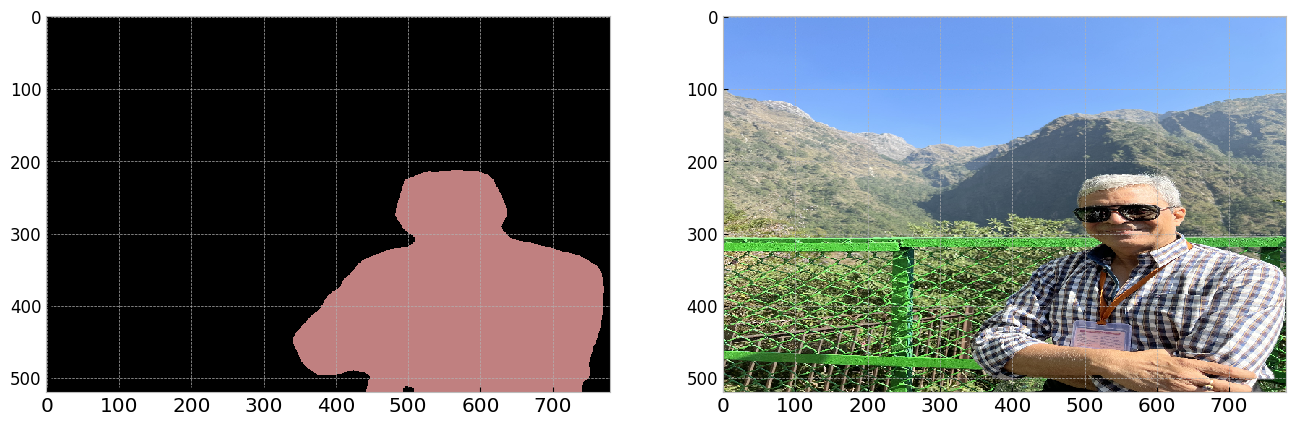

In [12]:
voc_labels = [
    Label(index=0, color=(0, 0, 0), name="background"),
    Label(index=1, color=(128, 0, 0), name="aeroplane"),
    Label(index=2, color=(0, 128, 0), name="bicycle"),
    Label(index=3, color=(128, 128, 0), name="bird"),
    Label(index=4, color=(0, 0, 128), name="boat"),
    Label(index=5, color=(128, 0, 128), name="bottle"),
    Label(index=6, color=(0, 128, 128), name="bus"),
    Label(index=7, color=(128, 128, 128), name="car"),
    Label(index=8, color=(64, 0, 0), name="cat"),
    Label(index=9, color=(192, 0, 0), name="chair"),
    Label(index=10, color=(64, 128, 0), name="cow"),
    Label(index=11, color=(192, 128, 0), name="dining table"),
    Label(index=12, color=(64, 0, 128), name="dog"),
    Label(index=13, color=(192, 0, 128), name="horse"),
    Label(index=14, color=(64, 128, 128), name="motorbike"),
    Label(index=15, color=(192, 128, 128), name="person"),
    Label(index=16, color=(0, 64, 0), name="potted plant"),
    Label(index=17, color=(128, 64, 0), name="sheep"),
    Label(index=18, color=(0, 192, 0), name="sofa"),
    Label(index=19, color=(128, 192, 0), name="train"),
    Label(index=20, color=(0, 64, 128), name="tv monitor")
]
VOCLabels = SegmentationMap(voc_labels)

# Convert the network result to a segmentation map and display the result.
result_mask_onnx = np.squeeze(np.argmax(res_onnx, axis=1)).astype(np.uint8)
viz_result_image(
    image,
    segmentation_map_to_image(result_mask_onnx, VOCLabels.get_colormap()),
    resize=True,
)

## OpenVINO IR Model in OpenVINO Runtime


In [13]:
#device_name="CPU"
device_name="GPU" # Using GPU


# Load the network in OpenVINO Runtime.
ie = Core()
model_ir = ie.read_model(model=ir_path)
compiled_model_ir = ie.compile_model(model=model_ir, device_name=device_name)

# Get input and output layers.
output_layer_ir = compiled_model_ir.output(0)

# Run inference on the input image.
res_ir = compiled_model_ir([normalized_input_image])[output_layer_ir]

75 warnings generated.
75 warnings generated.
75 warnings generated.
75 warnings generated.
75 warnings generated.
75 warnings generated.
75 warnings generated.
75 warnings generated.


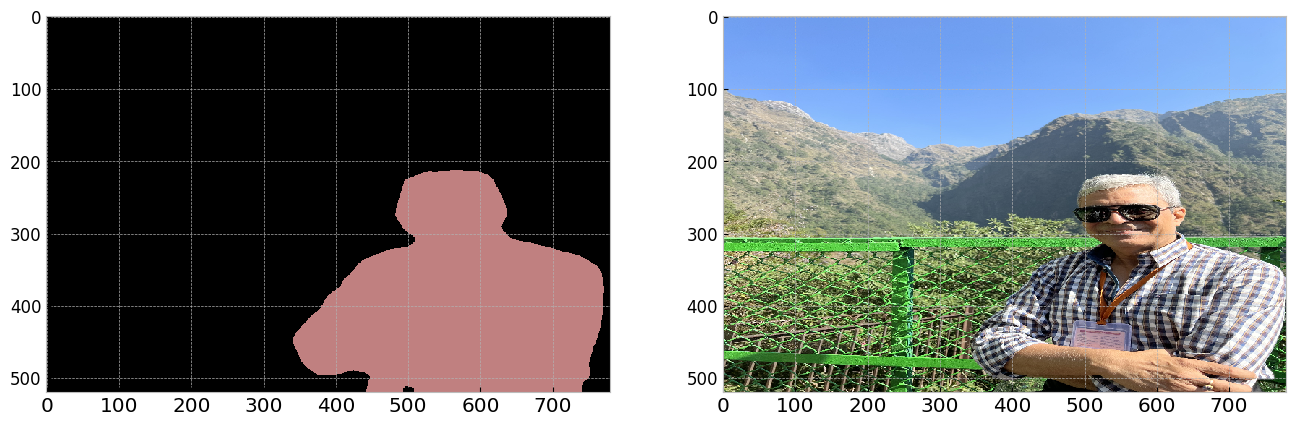

In [14]:
result_mask_ir = np.squeeze(np.argmax(res_ir, axis=1)).astype(np.uint8)
viz_result_image(
    image,
    segmentation_map_to_image(result=result_mask_ir, colormap=VOCLabels.get_colormap()),
    resize=True,
)
